# Training a CNN for DPU compilation
----

## Aim/s

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the MNIST handwritten digit dataset for deployment on the DPU. We will cover:

* Loading and pre-processing the imagenet dataset
* Training a CNN with Tensorflow2
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler

## References

* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Dec 13, 2021
    * Initial revision
----

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2022-03-28 16:17:19.166509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-03-28 16:17:19.166541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.6.0


## 1. Load dataset

The MNIST dataset comes with 60k training and 10k test examples that are
28x28 grayscale images, along with their labels which are just the 
corresponding digits saved as integers. We can use the `keras.datasets`
utility to load the MNIST dataset straight into our Jupyter environment.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))

Training data: (60000, 28, 28), (60000,)
Test data: (10000, 28, 28), (10000,)


In [4]:
print(x_train.shape)
print(x_train.dtype)
x_train = x_train[0:100]
print(y_train.shape)

(60000, 28, 28)
uint8
(60000,)


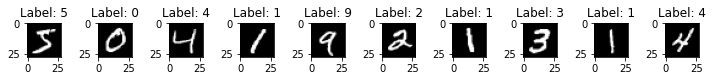

In [53]:
fig, axs = plt.subplots(1, 10, figsize=(10, 10))
plt.tight_layout()

for i in range(10):
    axs[i].imshow(x_train[i], 'gray')
    axs[i].set_title('Label: {}'.format(y_train[i]))

Next we will normalize the training and test images. We also need to add
color channel. All these pre-processing steps are required by Conv2D layers.

In [67]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train = tf.image.resize(x_train, [224,224])
x_test = tf.image.resize(x_test, [224,224])
print(x_train.shape)
print(x_train.dtype)


2022-03-03 17:07:12.338720: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12042240000 exceeds 10% of free system memory.


(60000, 224, 224, 1)
<dtype: 'float32'>


## 2. Train the model

Create a `tensorflow.keras.model` object by passing a list of layers. Because the MNIST dataset is not difficult, we can use a very simple network with a single convolutional layer.

In [14]:
inputs = tf.keras.Input(shape=(100,60,1))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_classifier')
model.summary()

Model: "mnist_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 60, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)          

In [12]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
inputs = Input(shape=(32, 32, 1))

# 卷积层和最大池化层
conv1 = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
conv2 = Conv2D(64, (3,3), padding='same', activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=2)(conv2)

conv3 = Conv2D(128, (3,3), padding='same', activation='relu')(pool1)
conv4 = Conv2D(128, (3,3), padding='same', activation='relu')(conv3)
pool2 = MaxPooling2D(pool_size=2)(conv4)

conv5 = Conv2D(256, (3,3), padding='same', activation='relu')(pool2)
conv6 = Conv2D(256, (3,3), padding='same', activation='relu')(conv5)
conv7 = Conv2D(256, (3,3), padding='same', activation='relu')(conv6)
pool3 = MaxPooling2D(pool_size=2)(conv7)

conv8 = Conv2D(512, (3,3), padding='same', activation='relu')(pool3)
conv9 = Conv2D(512, (3,3), padding='same', activation='relu')(conv8)
conv10 = Conv2D(512, (3,3), padding='same', activation='relu')(conv9)
pool4 = MaxPooling2D(pool_size=2)(conv10)

conv11 = Conv2D(512, (3,3), padding='same', activation='relu')(pool4)
conv12 = Conv2D(512, (3,3), padding='same', activation='relu')(conv11)
conv13 = Conv2D(256, (3,3), padding='same', activation='relu')(conv12)
pool5 = MaxPooling2D(pool_size=2)(conv13)

# 扁平层
flat = Flatten()(pool5)

# 全联接层
fc1 = Dense(1024, activation='relu')(flat)
fc2 = Dense(2048, activation='relu')(fc1)

# 输出层
outputs = Dense(10, activation='softmax')(fc2)


model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 8, 8, 128)         0   

In [5]:
inputs = tf.keras.Input(shape=(28,28,1))
x = tf.keras.layers.Conv2D(40, (9,9), activation='relu', input_shape=(28,28,1))(inputs)
x = tf.keras.layers.MaxPooling2D((3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_classifier')
model.summary( print_fn=None)
model.count_params()
model.get_config()
model.output
#model.get_layer(Conv2D)
#model.compute_output_shape(1)

Model: "mnist_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 40)        3280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1440)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               184448    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 189,018
Trainable params: 189,018
Non-trainable params: 0
____________________________________________

2022-02-22 04:56:44.522857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-02-22 04:56:44.522896: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 04:56:44.522927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-02-22 04:56:44.523136: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>

In [6]:
model.layers[2].output

<KerasTensor: shape=(None, 13, 13, 32) dtype=float32 (created by layer 'max_pooling2d')>

# Configure the model for training: choose desired optimizer, loss function and metrics to observe over the training period.

In [19]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

In [1]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from keras_flops import get_flops

# build model
# inp = Input((32, 32, 3))
# x = Conv2D(32, kernel_size=(3, 3), activation="relu")(inp)
# x = Conv2D(64, (3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)
# x = Flatten()(x)
# x = Dense(128, activation="relu")(x)
# x = Dropout(0.5)(x)
# out = Dense(10, activation="softmax")(x)
# model = Model(inp, out)

# Calculae FLOPS
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# >>> FLOPS: 0.0338 G
flops

2022-03-03 15:28:12.425072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-03-03 15:28:12.425107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'keras_flops'

Now we can train the model.

In [7]:
flops


24503457136

In [21]:
history = model.fit(x_train, y_train, epochs=1)

 120/1875 [>.............................] - ETA: 24:56 - loss: 2.3031 - accuracy: 0.1013

KeyboardInterrupt: 

We can inspect the training results by plotting the collected data in the
`history` object.

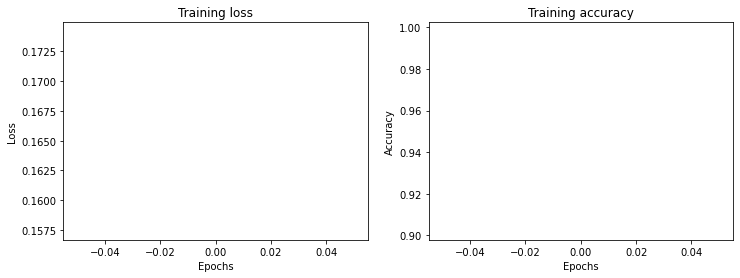

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

Evaluate the trained model on the test dataset.

In [30]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

313/313 [==============================] - 5s 15ms/step - loss: 0.0778 - accuracy: 0.9764
Test loss: 0.07777635753154755
Test accuracy: 0.9764000177383423


Currently the entire model graph is saved as a set of weights in floating point precision. We can make sure of that by printing out the dtype of one of the layers.

In [46]:
model.get_weights()[0].dtype

dtype('float32')

## 3. Quantization
In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

In [70]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [61]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test[1:1024], weight_bit=8, activation_bit=8)

[VAI INFO] Update custom_layer_type: []
[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 5s 589ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 326s 10s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.


In [72]:
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = x_test[1:8], weight_bit=8, activation_bit=8)

[VAI INFO] Update custom_layer_type: []
[VAI INFO] Update activation_bit: 8
[VAI INFO] Update weight_bit: 8
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 3s 385ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
1/1 [==============================] - 7s 7s/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [40]:
quantized_model.compile(loss='sparse_categorical_crossentropy', metrics=["accuracy"])

score = quantized_model.evaluate(x_test, y_test,  verbose=0, batch_size=32)
print(score)

[2.3026034832000732, 0.07329999655485153]


**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [73]:
quantized_model.save('tf2_mnist_classifier_quantized.h5')

## 4. Compilation

For this final step we use the Vitis AI compiler `vai_c_tensorflow2` and pass the quantized model as a parameter. In this example we are compiling the DPU model targeting the KV260 board, however to target a different board you will just have to point the compiler to the right `arch.json` file. 

For example, for the ZCU104 you would pass

`--arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json`

and for Ultra96, we can pass the custom arch.json in this repository

`--arch ./arch.json`

In [74]:
!vai_c_tensorflow2 \
    --model ./tf2_mnist_classifier_quantized.h5 \
    --arch ./arch.json \
    --output_dir ./xmodel \
    --net_name deploy

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./tf2_mnist_classifier_quantized.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/deploy_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/DPU-PYNQ/host/tf2_mnist_classifier_quantized.h5
[INFO] keras version: 2.6.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 67/67 [00:00<00:00, 67.60it/s]              
[INFO] dump xmodel: /tmp/deploy_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B2304_MAX_BG2
[UNILOG][INFO] Graph name: model_8, with op num: 125
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved 

In [39]:
x=3
os.rename("./xmodel/deploy.xmodel","./xmodel/mnist_{}.xmodel".format(x))

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----